In [1]:
#importing the libraries
import torch 
import torch.nn as nn
from torchvision import datasets,models,transforms,ops
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import os
import time
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [2]:
def convert_to_bbox_cord(yolo_tensor_aug):
  num_cells_along_width = 8
  yolo_interval = 32
  #Keeping track of index for which anchor box is best for all 64 cells
  best_ancbox_for_cell = {cx : None for cx in range(64)}
  for cx in range(yolo_tensor_aug.shape[0]):
    curr_best = 0
    cell_tensor = yolo_tensor_aug[cx] #Shape (5x9)
    #Finding the anchor box index for which the object has highest probability of being present in a cell
    for ax in range(cell_tensor.shape[0]):
      if cell_tensor[ax][0] > cell_tensor[curr_best][0]: 
        curr_best = ax    
    best_ancbox_for_cell[cx] = curr_best

  #Sorting this dictionary in descending order of probability of a cell having an object
  sorted_icx = sorted(best_ancbox_for_cell,key=lambda x: yolo_tensor_aug[x,best_ancbox_for_cell[x]][0].item(), reverse=True)
  retained_cells_idxs = sorted_icx[:5]

  #Extracting the labels and bounding boxes from the top 5 cells
  labels = []
  bbox = []
  for cx in retained_cells_idxs:
    yolo_vector = yolo_tensor_aug[cx,best_ancbox_for_cell[cx],:] #Extracting the yolo vector
    class_label_prob_all = nn.Softmax(dim=0)(yolo_vector[5:]) #Applying softmax to the class labels
    class_label_prob = class_label_prob_all[:-1]
    if yolo_vector[0]<0.25:
      continue
    else:
      #Extracting the label
      labels.append(torch.argmax(class_label_prob).item())

      #Extracting the height and width of the bounding box
      h = yolo_vector[3].item()*yolo_interval
      w = yolo_vector[4].item()*yolo_interval

      #Extracting the center coordinate of the bounding box wrt the cell
      del_x = yolo_vector[1].item()
      del_y = yolo_vector[2].item()

      #Getting the cell coordinates
      cell_row_idx = cx//num_cells_along_width
      cell_col_idx = cx%num_cells_along_width

      #Finding the yolo cell center coordinates
      cell_center_i = (cell_row_idx*yolo_interval + float(yolo_interval)) / 2.0 
      cell_center_j = (cell_col_idx*yolo_interval + float(yolo_interval)) / 2.0 

      #Finding the center coordinates of the bounding box
      bb_height_center = del_x*yolo_interval + cell_center_j  
      bb_width_center =  del_y*yolo_interval + cell_center_i

      #Finding top left and right of the bounding box
      x =  bb_width_center - w/2.0
      y =  bb_height_center - h/2.0 
      bbox.append([x,y,x+w,y+h])
  
  return torch.Tensor(bbox),torch.Tensor(labels)                                                                


In [3]:
class IndexedDataset(Dataset):

    def __init__(self, dir_path):
        self.dir_path = dir_path
        
        if os.path.basename(self.dir_path) == 'train': #transforms for the train dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
          f = open('Dataset/dict_train.json')
          self.bbox_data = json.load(f)
          f.close()
          self.loc = "Dataset\\train\\"  
          
        elif os.path.basename(self.dir_path) == 'test': #transforms for the test dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
          f = open('Dataset/dict_test.json')
          self.bbox_data = json.load(f)
          f.close()
          self.loc = "Dataset\\test\\"
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path): #Saving all the image locations
            image_filenames += [os.path.join(dirpath, file) for file in filenames]
        self.image_filenames = image_filenames    
        self.labels_map = {"bus" : 0, "cat": 1, "pizza" : 2} #Creating hashmap of the class and a number

    def __len__(self):
        return len(self.image_filenames)

    def convert_to_yolo_tensor(self,bbox,label):
      #bbox is of shape (number_of_objects x 4)
      #label is of shape (number_of_objects)
  
      yolo_interval = 32
      cell_height = yolo_interval
      cell_width = yolo_interval
      num_cells_along_width = 8
      num_cells_along_height = 8
      yolo_tensor = torch.zeros(64,5,8)
      yolo_tensor_aug = torch.zeros(64,5,9)

      for ix in range(len(bbox)):
        #Center coordinates of the bounding box  
        bb_height_center = (bbox[ix,1] + bbox[ix,3])/2.0 
        bb_width_center = (bbox[ix,0] + bbox[ix,2])/2.0

        #height and width bounding box 
        obj_bb_height = bbox[ix,3] - bbox[ix,1]
        obj_bb_width = bbox[ix,2] - bbox[ix,0]
          
        #Finding the index of the yolo cell
        cell_row_indx = int(bb_height_center / yolo_interval)
        cell_col_indx = int(bb_width_center / yolo_interval)
           
        #Center coordinates of the yolo cell
        cell_center_i = (cell_row_indx*yolo_interval + float(yolo_interval)) / 2.0 
        cell_center_j = (cell_col_indx*yolo_interval + float(yolo_interval)) / 2.0 

        #Center coordinates of the bounding box wrt to the yolo cell
        del_x = (bb_height_center - cell_center_j) / yolo_interval 
        del_y = (bb_width_center - cell_center_i) / yolo_interval

        #Height and width of the bounding box wrt to the yolo cell
        bh = obj_bb_height/ yolo_interval 
        bw = obj_bb_width/ yolo_interval

        #Finding the correct anchor box
        ratio = obj_bb_height/obj_bb_width
        if ratio <= 0.2: 
          anc_box_i = 0 
        elif 0.2 < ratio <= 0.5: 
          anc_box_i = 1
        elif 0.5 < ratio <= 1.5: 
          anc_box_i = 2 
        elif 1.5 < ratio <= 4.0: 
          anc_box_i = 3 
        elif ratio > 4.0: 
          anc_box_i = 4

        #Constructing the yolo vector
        yolo_vector = torch.FloatTensor([1,del_x.item(), del_y.item(), bh.item(), bw.item(), 0, 0, 0] ) 
        yolo_vector[5 + int(label[ix].item())] = 1

        #Inserting the yolo vector into the yolo tensor 
        cell_index = cell_row_indx * num_cells_along_width + cell_col_indx
        yolo_tensor[cell_index, anc_box_i] = yolo_vector
        
      ## If no object is present, throw all the probability mass into the extra 9th element of yolo vector
      yolo_tensor_aug[:,:,:-1] = yolo_tensor[:,:,:]
      for cx in range(64): # Over all the yolo cells
        for ax in range(5): #  Over all the anchor boxes
          if yolo_tensor_aug[cx,ax,0] == 0: 
            yolo_tensor_aug[cx,ax,-1] = 1

      return yolo_tensor_aug  

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        bbox_loc  = self.loc + os.path.basename(img_name)
        bbox = self.bbox_data[bbox_loc]
        cl = []
        bb = []
        for i in range(len(bbox)):
          cl.append(self.labels_map[bbox[i][1]])
          b = bbox[i][0]
          bb.append(b)    
        #x and y have traditional math notations
        #Changing the last two variables from w,h to x2,y2
        bb = torch.Tensor(bb)
        bb[:,2] = bb[:,2]+bb[:,0]
        bb[:,3] = bb[:,3]+bb[:,1]
        
        yolo_tensor = self.convert_to_yolo_tensor(bb,torch.Tensor(cl))

        return image, yolo_tensor


In [4]:
#Function to Plot the image with the ground truth annotation
def plot_image_ground(dataset,index):
  img = dataset[index][0] #Getting the image
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous
  labels_map = {0:"bus", 1: "cat", 2: "pizza"}

  #Getting the ground truth bounding box and labels
  yolo_tensor = dataset[index][1] 
  bbox, labels = convert_to_bbox_cord(yolo_tensor)

  #Plotting the ground truth bounding boxes
  for i in range(len(labels)):
    cl = labels_map[int(labels[i].item())] #Class of the image
    [x1,y1,x2,y2] = bbox[i] #Getting the ground truth bounding box coordinates     
    ci = cv2.rectangle(ci,(int(x1),int(y1)),(int(x2),int(y2)),(36,255,12),2) #drawing the ground truth bounding box
    ci = cv2.putText(ci,cl,(int(x1),int(y1-10)),cv2.FONT_HERSHEY_SIMPLEX,0.8,(36,255,12),2)
  
  return ci.astype(int)  #returns the image with the bounding box
  
  

In [5]:
train_dataset = IndexedDataset("Dataset/train")
print(len(train_dataset))

6883


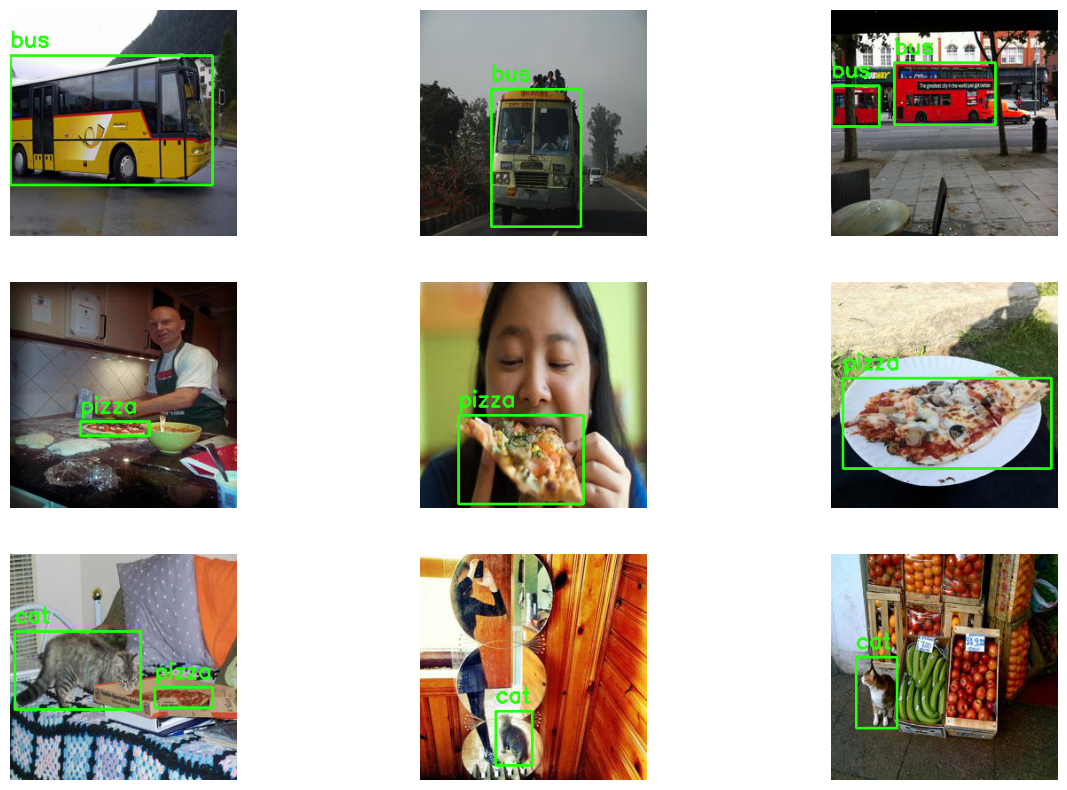

In [6]:
#Plotting 9 images along with ground truth annotations
fig = plt.figure(figsize = (15,10))

ax11 = fig.add_subplot(3,3,1)
ax12 = fig.add_subplot(3,3,2)
ax13 = fig.add_subplot(3,3,3)

ax11.axis('off')
ax12.axis('off')
ax13.axis('off')

ax11.imshow(plot_image_ground(train_dataset,1))
ax12.imshow(plot_image_ground(train_dataset,2))
ax13.imshow(plot_image_ground(train_dataset,6))

ax21 = fig.add_subplot(3,3,4)
ax22 = fig.add_subplot(3,3,5)
ax23 = fig.add_subplot(3,3,6)

ax21.axis('off')
ax22.axis('off')
ax23.axis('off')

ax21.imshow(plot_image_ground(train_dataset,801))
ax22.imshow(plot_image_ground(train_dataset,800))
ax23.imshow(plot_image_ground(train_dataset,806))

ax31 = fig.add_subplot(3,3,7)
ax32 = fig.add_subplot(3,3,8)
ax33 = fig.add_subplot(3,3,9)

ax31.axis('off')
ax32.axis('off')
ax33.axis('off')

ax31.imshow(plot_image_ground(train_dataset,1899))
ax32.imshow(plot_image_ground(train_dataset,1902))
ax33.imshow(plot_image_ground(train_dataset,804))
